In [25]:
# ======================================================
# Pipeline completa per Algo Trading con Deep Learning
# ======================================================

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 1. Scaricamento dei dati per la stock MSFT
ticker = "AAPL"
df = yf.download(ticker, start="2010-01-01", end="2024-01-01", interval="1d")
df.dropna(inplace=True)

# Aggiungiamo un indicatore tecnico: SMA a 20 giorni
df['SMA20'] = df['Close'].rolling(window=20).mean()
df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [26]:
# 2. Preprocessing e creazione delle features
# Utilizziamo due features: "Close" e "SMA20"
features = df[['Close', 'SMA20']].values

# Scaling: normalizziamo le features tra 0 e 1
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Funzione per creare sequenze temporali per il modello LSTM:
# Ogni sequenza (lunghezza = 60 giorni) viene usata per predire il prezzo di chiusura del giorno successivo
def create_sequences(data, seq_length, target_index=0):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        # Il target è il prezzo di chiusura (prima colonna) del giorno successivo
        targets.append(data[i+seq_length, target_index])
    return np.array(sequences), np.array(targets)

SEQ_LENGTH = 60
X, y = create_sequences(scaled_features, seq_length=SEQ_LENGTH, target_index=0)

# 3. Divisione in train/test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Conversione in tensori PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32)

In [39]:
# 4. Creazione del Dataset e DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset  = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 5. Definizione del modello LSTM
# Poiché usiamo due features ("Close" e "SMA20"), input_size=2
class LSTMModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

model = LSTMModel(input_size=2, hidden_size=50, num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 6. Addestramento del modello
EPOCHS = 20
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validazione sul test set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.view(-1, 1))
            val_loss += loss.item()
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")

Epoch 1/20 - Train Loss: 0.032967 - Val Loss: 0.449871
Epoch 2/20 - Train Loss: 0.021357 - Val Loss: 0.423447
Epoch 3/20 - Train Loss: 0.021416 - Val Loss: 0.421565
Epoch 4/20 - Train Loss: 0.021332 - Val Loss: 0.422647
Epoch 5/20 - Train Loss: 0.021236 - Val Loss: 0.422367
Epoch 6/20 - Train Loss: 0.021305 - Val Loss: 0.423132
Epoch 7/20 - Train Loss: 0.021255 - Val Loss: 0.422357


KeyboardInterrupt: 

In [34]:
# 7. Valutazione del modello sulle predizioni del test set
model.eval()
y_preds = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        preds = model(X_batch)
        y_preds.extend(preds.squeeze().tolist())

# Convertiamo le predizioni e i target alla scala originale.
# Poiché abbiamo scalato due features e il target è il primo valore (Close), creiamo array dummy per "SMA20" 
y_test_scaled = y_test.numpy().reshape(-1, 1)
y_preds_scaled = np.array(y_preds).reshape(-1, 1)
dummy = np.zeros_like(y_test_scaled)

# Ricostruiamo array a due colonne per invertire lo scaling
test_scaled_full = np.hstack([y_test_scaled, dummy])
preds_scaled_full = np.hstack([y_preds_scaled, dummy])

# Inverse transform per ottenere i prezzi reali
y_test_actual = scaler.inverse_transform(test_scaled_full)[:,0]
y_preds_actual = scaler.inverse_transform(preds_scaled_full)[:,0]

# Calcolo delle metriche di valutazione
mse_val = mean_squared_error(y_test_actual, y_preds_actual)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_test_actual, y_preds_actual)
r2_val  = r2_score(y_test_actual, y_preds_actual)

print("\nMetriche di valutazione:")
print(f"MSE: {mse_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")
print(f"MAE: {mae_val:.4f}")
print(f"R²: {r2_val:.4f}")


Metriche di valutazione:
MSE: 445.9851
RMSE: 21.1184
MAE: 18.2697
R²: -0.2499


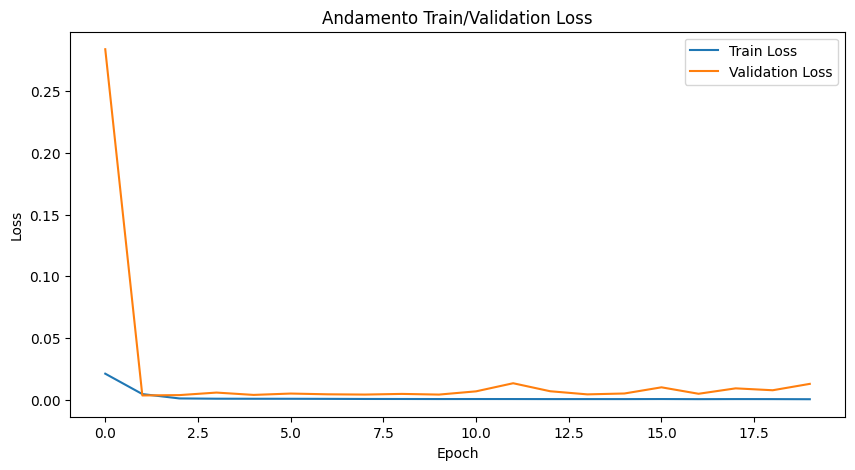

In [35]:
# 8. Grafici delle performance del modello
# a) Andamento di Train e Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Andamento Train/Validation Loss")
plt.legend()
plt.show()

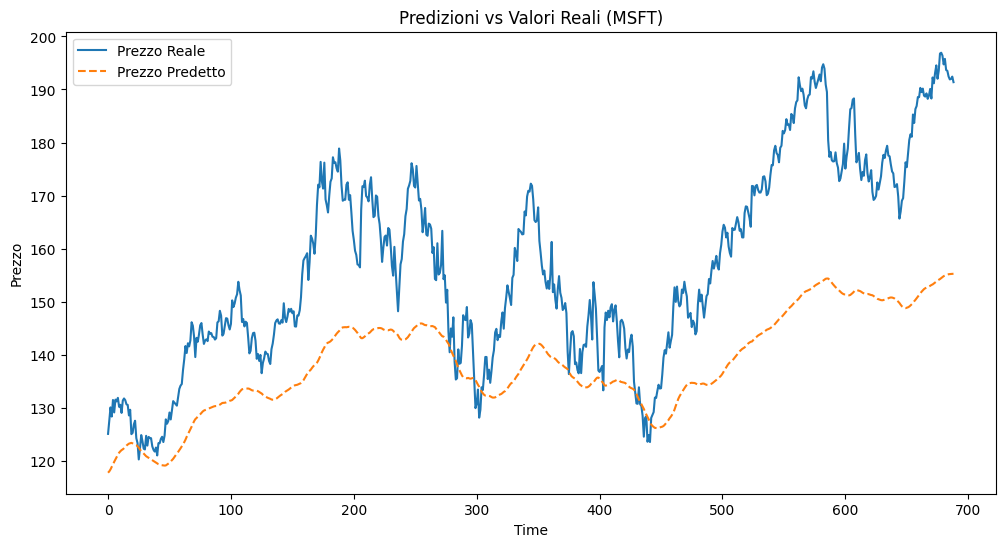

In [36]:
# b) Predizioni vs Valori Reali
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Prezzo Reale")
plt.plot(y_preds_actual, label="Prezzo Predetto", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Prezzo")
plt.title("Predizioni vs Valori Reali (MSFT)")
plt.legend()
plt.show()

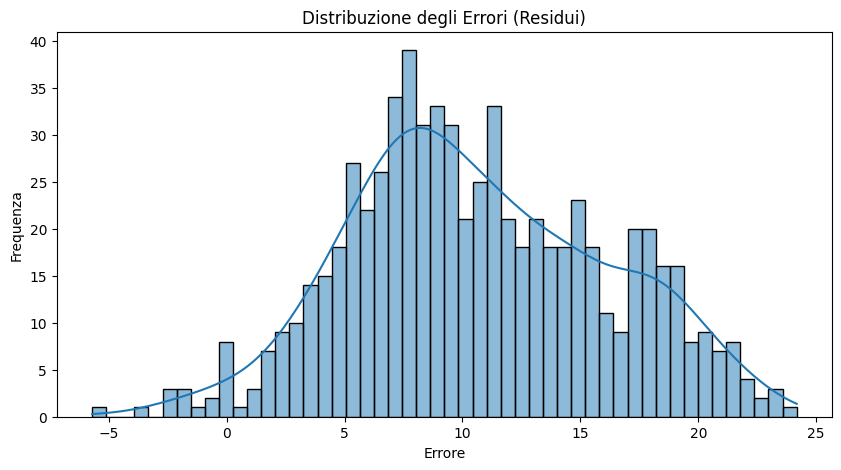

In [20]:
# c) Distribuzione degli errori (Residui)
errors = y_test_actual - y_preds_actual
plt.figure(figsize=(10,5))
sns.histplot(errors, bins=50, kde=True)
plt.title("Distribuzione degli Errori (Residui)")
plt.xlabel("Errore")
plt.ylabel("Frequenza")
plt.show()

In [21]:
# 9. Generazione di segnali per Algo Trading
# Strategia semplice:
# Se la predizione del giorno t (y_preds_actual[t]) è superiore al prezzo reale del giorno precedente (y_test_actual[t-1]), allora genera segnale "Buy" (1), altrimenti "Cash" (0)
signals = np.zeros_like(y_preds_actual)
for i in range(1, len(y_preds_actual)):
    if y_preds_actual[i] > y_test_actual[i-1]:
        signals[i] = 1  # segnale long
    else:
        signals[i] = 0  # nessun investimento

# 10. Backtesting della strategia
# Calcoliamo i rendimenti giornalieri sulla base dei prezzi reali del test set
returns = (y_test_actual[1:] - y_test_actual[:-1]) / y_test_actual[:-1]

# I rendimenti della strategia sono applicati quando il segnale del giorno precedente è "1"
strategy_returns = signals[:-1] * returns

# Rendimenti cumulativi della strategia e confronto con una strategia Buy & Hold
cumulative_strategy_returns = np.cumprod(1 + strategy_returns) - 1
cumulative_buy_hold = np.cumprod(1 + returns) - 1

# Calcolo dello Sharpe Ratio (assumendo 252 giorni di trading)
sharpe_ratio = np.mean(strategy_returns) / np.std(strategy_returns) * np.sqrt(252)
print(f"\nSharpe Ratio della strategia: {sharpe_ratio:.4f}")


Sharpe Ratio della strategia: 1.0201


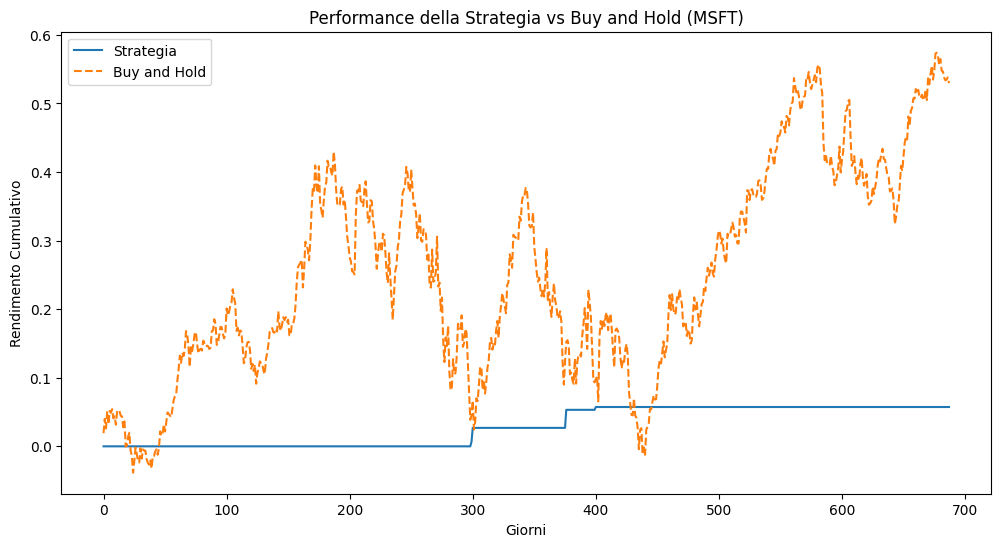

In [22]:
# Grafico dei rendimenti cumulativi
plt.figure(figsize=(12,6))
plt.plot(cumulative_strategy_returns, label="Strategia")
plt.plot(cumulative_buy_hold, label="Buy and Hold", linestyle='--')
plt.xlabel("Giorni")
plt.ylabel("Rendimento Cumulativo")
plt.title("Performance della Strategia vs Buy and Hold (MSFT)")
plt.legend()
plt.show()

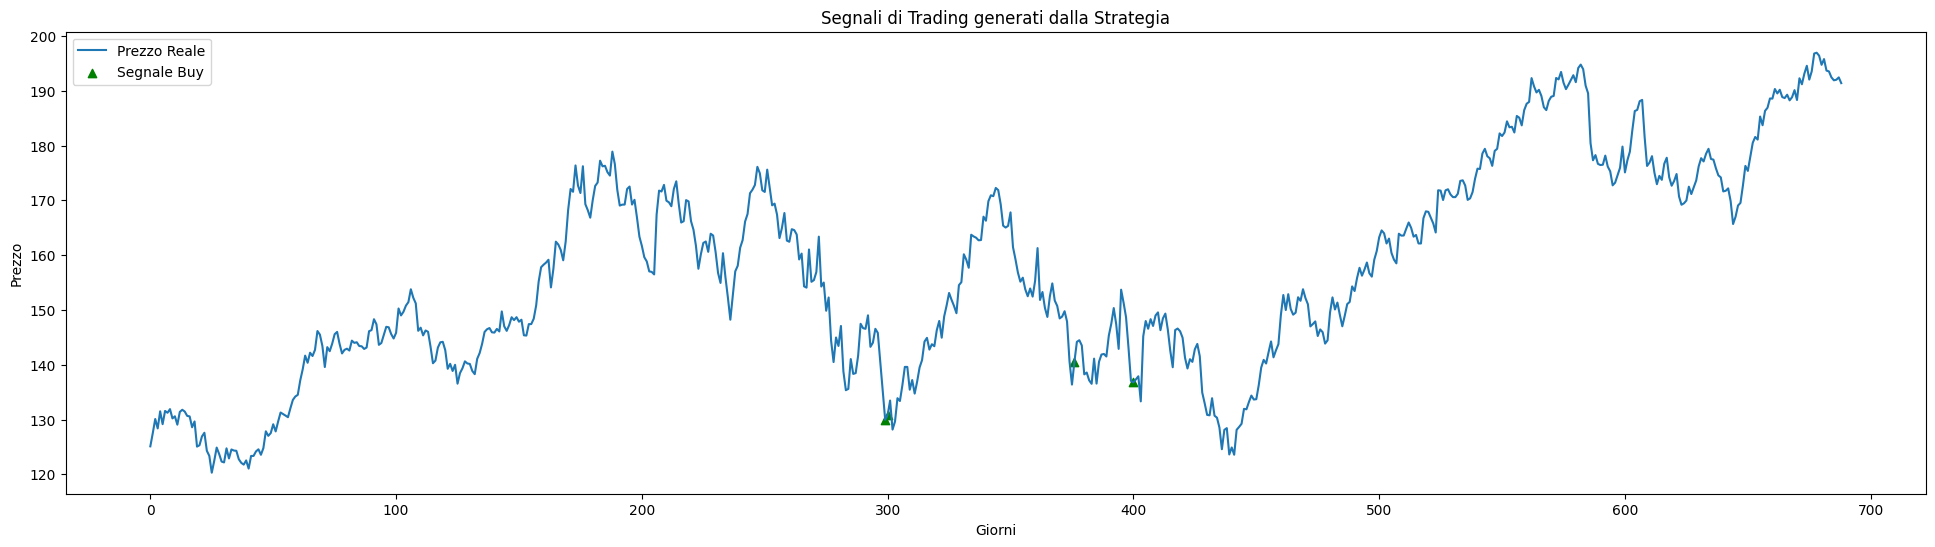

In [23]:
# d) Visualizzazione dei segnali sul grafico dei prezzi
plt.figure(figsize=(24,6))
plt.plot(y_test_actual, label="Prezzo Reale")
buy_signals = np.where(signals==1)[0]
plt.scatter(buy_signals, y_test_actual[buy_signals], marker="^", color="green", label="Segnale Buy")
plt.xlabel("Giorni")
plt.ylabel("Prezzo")
plt.title("Segnali di Trading generati dalla Strategia")
plt.legend()
plt.show()

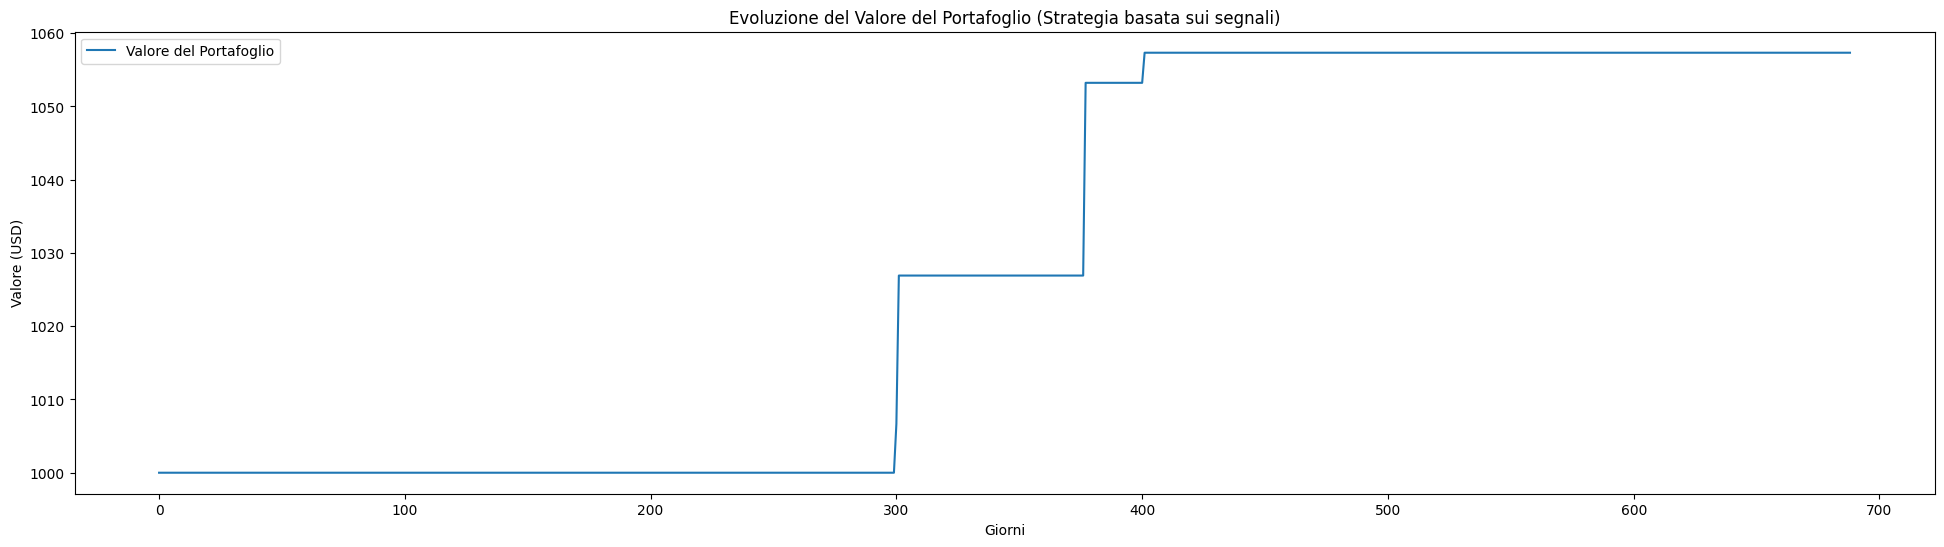

Portfolio finale: $1057.34
Profitto: $57.34 (5.73%)


In [24]:
# ------------------------------------------------------
# Stima dei guadagni seguendo i segnali dell'algoritmo
# ------------------------------------------------------

# Calcolo dei rendimenti giornalieri sul test set
# Assumiamo che y_test_actual sia un array con i prezzi reali (scala originale)
returns = (y_test_actual[1:] - y_test_actual[:-1]) / y_test_actual[:-1]

# I segnali (signals) sono stati generati in precedenza:
# Ad esempio:
# signals = np.zeros_like(y_preds_actual)
# for i in range(1, len(y_preds_actual)):
#     if y_preds_actual[i] > y_test_actual[i-1]:
#         signals[i] = 1  # segnale di acquisto
#     else:
#         signals[i] = 0  # nessun segnale
#
# Verifica che "signals" abbia la stessa lunghezza di y_preds_actual (o y_test_actual).

# Simulazione della strategia
initial_capital = 1000.0  # Capitale iniziale in USD
capital = initial_capital
portfolio_values = [capital]  # Per tracciare l'evoluzione del portafoglio

# Per ogni giorno (a partire dal primo rendimento calcolato) se il segnale è 1 investiamo (all-in)
# Altrimenti restiamo in cash (nessun cambiamento di capitale)
for i in range(len(returns)):
    if signals[i] == 1:
        # Se il segnale è buy, il capitale viene aggiornato applicando il rendimento del giorno
        capital = capital * (1 + returns[i])
    # Se non investiamo, il capitale rimane invariato.
    portfolio_values.append(capital)

# Plot dell'evoluzione del valore del portafoglio
import matplotlib.pyplot as plt

plt.figure(figsize=(24,6))
plt.plot(portfolio_values, label="Valore del Portafoglio")
plt.xlabel("Giorni")
plt.ylabel("Valore (USD)")
plt.title("Evoluzione del Valore del Portafoglio (Strategia basata sui segnali)")
plt.legend()
plt.show()

# Calcolo del guadagno finale
final_capital = portfolio_values[-1]
profit = final_capital - initial_capital
profit_pct = (profit / initial_capital) * 100

print(f"Portfolio finale: ${final_capital:.2f}")
print(f"Profitto: ${profit:.2f} ({profit_pct:.2f}%)")